# Project OT -- Annealed Sinkhorn for Optimal Transport: convergence, regularization path and debiasing

**By** : [Channdeth SOK](channdeth.sok@ensae.fr) (ENSAE Paris - M2DS)

**Reference** : [Lénaïc Chizat (2024). Annealed Sinkhorn for Optimal Transport: convergence, regularization path and debiasing. ArXiv, abs/2408.11620.](https://arxiv.org/pdf/2408.11620)

In [27]:
import sys

if "google.colab" in sys.modules:
    !pip install --upgrade "jax[cpu]"
    !pip install -q git+https://github.com/ott-jax/ott@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Introduction
Optimal Transport (OT) problems in the discrete case aim to find a minimum-cost plan $\pi$ transporting one distribution $p$ to another $q$​.
$$\mathrm{OT}(p, q) := \min_{\pi \in \Gamma(p, q)} \langle c, \pi \rangle,$$
where $\Gamma(p, q) := \left\{ \pi \in \mathbb{R}_+^{m \times n} \,\middle|\, \pi \mathbf{1} = p \text{ and } \pi^\top \mathbf{1} = q \right\}$ is the set of transportation plans

Sinkhorn’s algorithm addresses OT by introducing an entropic regularization $\varepsilon$ (or inverse temperature $\beta = 1/\varepsilon$) that smooths the problem​. It alternates between scaling the transport plan to match $p$ and $q$ (the famous matrix scaling iterations) and converges to the entropy-regularized OT solution​.
$$
\mathrm{EOT}_{\beta}(p, q) := \min_{\pi \in \Gamma(p, q)} \langle c, \pi \rangle + \beta^{-1} \, \mathrm{KL}(\pi \mid \pi^{\mathrm{ref}})
$$
The smaller the regularization (larger $\beta$), the closer this solution is to the true OT. However, lower regularization also slows convergence, leads to a **speed–accuracy trade-off**.

**Annealed Sinkhorn** is a heuristic to improve this trade-off by gradually increasing $\beta$ during iterations instead of keeping it fixed​. Intuitively, one starts with a high entropy (small $\beta$) for speed, then slowly increases $\beta$ for accuracy. Despite empirical success, the convergence of Annealed Sinkhorn was not fully understood until [Chizat (2024)](https://arxiv.org/pdf/2408.11620).

The paper "Annealed Sinkhorn for Optimal Transport: convergence, regularization path and debiasing" provides some main insights:
- **Convergence Conditions**: Annealed Sinkhorn will still solve the original OT exactly if and only if the schedule ${\beta_t}$ goes to infinity and increments slow down to 0 (${β_t - β_{t-1} \to 0}$)​. In practice, $\beta_t$ must increase concavely (diminishing increments)​. A classic choice meeting this is $\beta_t \sim \log t$, but this grows very slowly. The best proven schedule is $\beta_t = \Theta(\sqrt{t})$, which yields an error decaying on the order of $t^{-1/2}$​. However, even this $\sqrt{t}$ schedule is relatively slow.

- **Regularization vs. Relaxation Error**: As $\beta$ increases, two error components affect the solution at iteration $t$:

  (1) the entropic bias (difference between solving OT with finite $\beta_t$ vs. infinite $\beta$) which is $O(1/\beta_t)$​, and

  (2) a relaxation error from not fully equilibrating at each step, proportional to $\Delta \beta_t = \beta_t - \beta_{t-1}$​. With a $\sqrt{t}$ schedule, these two errors balance (both ~$t^{-1/2}$), giving the optimal trade-off for standard annealing​.

- **Debiased Annealed Sinkhorn**: To push beyond this limit, the paper introduces a simple modification to reduce the relaxation error​. The so-called Debiased Annealed Sinkhorn algorithm corrects for the lag induced by increasing $\beta$ and allows using much faster-growing schedules​. In fact, theory predicts an improved optimal schedule $\beta_t \sim t^{2/3}$ for the debiased version​, and experiments show one can even take $\beta_t$ roughly linear in $t$ (much faster than $\sqrt{t}$) without losing convergence​. The result is striking: a single run of Debiased Annealed Sinkhorn can span the entire speed–accuracy Pareto front of standard Sinkhorn​.  In other words, it achieves the accuracy of a very high $\beta$ Sinkhorn in the time it would normally take a low $\beta$ Sinkhorn to converge.

## Synthetic Data : Data Generation

We will use two types of cost structures as in the paper:
- a geometric cost with *structured* data
- an *unstructured* random cost matrix

Setup: We create two distributions $p$ and $q$ of size $n$ (e.g. $n=300$) and a cost matrix $C$. For the geometric scenario, let’s sample points in 2D and use squared Euclidean distance as cost; for the unstructured scenario, use random i.i.d. costs. Both $p$ and $q$ will be uniform distributions for simplicity (though any weights are possible).

In [28]:
import jax
from jax.scipy.special import logsumexp
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

from ott.geometry import costs, pointcloud, geometry
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

import matplotlib.pyplot as plt
from IPython import display

In [29]:
# Set random key
key = jax.random.PRNGKey(1)
key, key_rand, key_x, key_y = jax.random.split(key, 4)

# Number of points
m, n = 300, 300

# Uniform weights
p = jnp.ones(m) / m
q = jnp.ones(n) / n

# Random Cost Matrix

# Create random cost matrix
cost_rand = jax.random.normal(key_rand, (m, n))

# Normalize cost
cost_rand = (cost_rand - cost_rand.min()) / (cost_rand.max() - cost_rand.min())

# Geometry object
geom_rand = geometry.Geometry(cost_matrix=cost_rand)


In [30]:
# geom_rand.cost_matrix

In [33]:
# Geometric (Pointcloud)
# Generate X points
ang1 = jax.random.uniform(key_x, (m//2,)) * jnp.pi
rad1 = jax.random.uniform(key_x, (m//2,)) * 0.2 + 0.3
X1 = jnp.stack([rad1 * jnp.cos(ang1), rad1 * jnp.sin(ang1)], axis=1)

ang2 = jax.random.uniform(key_x, (m//2,)) * 2 * jnp.pi
rad2 = jax.random.uniform(key_x, (m//2,)) * 0.1
X2 = jnp.stack([rad2 * jnp.cos(ang2) - 0.3, rad2 * jnp.sin(ang2) + 0.4], axis=1)

X = jnp.concatenate([X1, X2], axis=0)

# Generate Y points
Y1 = jnp.stack([jax.random.uniform(key_y, (n//2,)) - 0.5, jax.random.uniform(key_y, (n//2,)) * 0.15], axis=1)
Y2 = jnp.stack([(jax.random.uniform(key_y, (n//2,)) - 0.5) * 0.15, jax.random.uniform(key_y, (n//2,)) * 0.6], axis=1)
Y = jnp.concatenate([Y1, Y2], axis=0)
# Pointcloud
geom_pc = pointcloud.PointCloud(X, Y, cost_fn=costs.SqEuclidean())

In [34]:
# geom_pc.cost_matrix

In [36]:
# Utility for plot
def plot_map(x, y, x_new=None, z=None, ax=None, title=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(8, 5))

    ax.scatter(*x.T, s=100, edgecolors="k", marker="o", label=r"$x$")
    ax.scatter(*y.T, s=100, edgecolors="k", marker="X", label=r"$y$")
    if z is not None:
        ax.quiver(
            *x_new.T,
            *(z - x_new).T,
            color="k",
            angles="xy",
            scale_units="xy",
            scale=1,
            width=0.007,
        )
        ax.scatter(
            *x_new.T, s=1, edgecolors="k", marker="o", label="$x_{new}$"
        )
        ax.scatter(
            *z.T,
            s=150,
            edgecolors="k",
            marker="X",
            label=r"$T_{x\rightarrow y}(x_{new})$",
        )
    if title is not None:
        ax.set_title(title)
    ax.legend(fontsize=22)


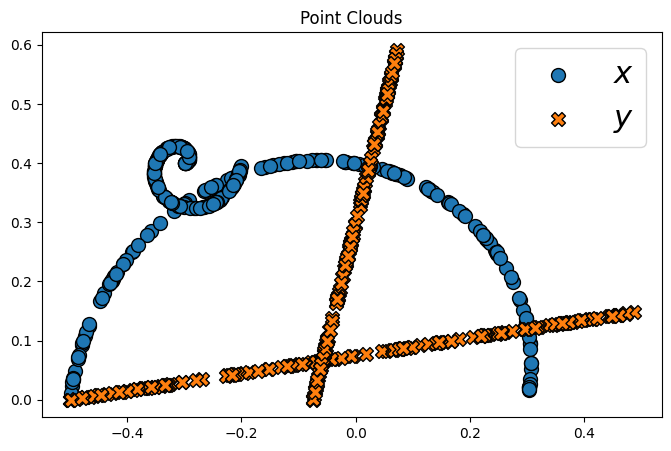

In [37]:
plot_map(X,Y)
plt.title("Point Clouds")
plt.show()

We use Sinkhorn with a very small ε to approximate the unregularized OT cost, and compare it to the exact value from the Hungarian algorithm for verification.

In [38]:
# Approximate true cost using sinkhorn with small epsilon
prob_rand = linear_problem.LinearProblem(geom_rand, a=p, b=q)

# Solve with unregularized OT
solver = sinkhorn.Sinkhorn()
out_rand = solver(prob_rand)

# Compute OT cost
true_ot_cost_rand = jnp.sum(out_rand.matrix * cost_rand)
print(f"(True) Random cost matrix OT cost: {true_ot_cost_rand:.6f}")

# Solve problem
prob_pc = linear_problem.LinearProblem(geom_pc, a=p, b=q)
out_pc = solver(prob_pc)

# Optimal transport cost
true_ot_cost_pc = jnp.sum(out_pc.matrix * geom_pc.cost_matrix)
print(f"(True) Geometric pointcloud OT cost: {true_ot_cost_pc:.6f}")

(True) Random cost matrix OT cost: 0.175934
(True) Geometric pointcloud OT cost: 0.090292


In [39]:
from scipy.optimize import linear_sum_assignment

# Random cost matrix case
row_ind, col_ind = linear_sum_assignment(cost_rand)
true_ot_cost_rand = cost_rand[row_ind, col_ind].sum() / n  # if uniform marginals (dividing by n)

print(f"(True) Random cost matrix OT cost: {true_ot_cost_rand:.6f}")

# Geometric pointcloud case
row_ind, col_ind = linear_sum_assignment(geom_pc.cost_matrix)
true_ot_cost_pc = geom_pc.cost_matrix[row_ind, col_ind].sum() / n

print(f"(True) Geometric pointcloud OT cost: {true_ot_cost_pc:.6f}")


(True) Random cost matrix OT cost: 0.174584
(True) Geometric pointcloud OT cost: 0.086800


## Baseline: Fixed Regularization

In [40]:
# Here by using OTT-JAX with custom progress_fn to get the gap cost each iteration
# tracked_gaps = []
# def projection_plan(p, q, pi):
#     a = jnp.minimum(p / jnp.sum(pi, axis=1), 1.0)
#     pi_temp = (a[:, None]) * pi
#     b = jnp.minimum(q / jnp.sum(pi_temp, axis=0), 1.0)
#     pi_temp = pi_temp * b[None, :]
#     delta_p = p - jnp.sum(pi_temp, axis=1)
#     delta_q = q - jnp.sum(pi_temp, axis=0)
#     # correction = jnp.outer(delta_p, delta_q) / jnp.sum(delta_p)
#     correction = jnp.outer(delta_p, delta_q) / jnp.sum(jnp.abs(delta_p))
#     return pi_temp + correction
# def make_gap_tracker(geom,epsilon, true_cost, a, b):
#     def my_gap_tracker(state):
#         f, g = state.potentials
#         C = geom.cost_matrix
#         eps = epsilon
#         pi = jnp.exp(f[:, None] + g[None, :] - C / eps)
#         pi_proj = projection_plan(a, b, pi)
#         cost = jnp.sum(C * pi_proj)
#         gap = cost - true_cost
#         tracked_gaps.append(gap)
#     return my_gap_tracker
# gap_tracker = make_gap_tracker(geom_pc,epsilon, true_ot_cost_pc, p, q)

# def progress_fn(status):
#     iteration, inner_iter, total_iter, state = status
#     gap_tracker(state)

# beta = 1000.0
# epsilon = 1.0 / beta

# geom_eps = geometry.Geometry(cost_matrix=geom_pc.cost_matrix, epsilon=epsilon)
# prob = linear_problem.LinearProblem(geom_eps, a=p, b=q)

# solver = sinkhorn.Sinkhorn(progress_fn=progress_fn, max_iterations=1000,threshold=0, lse_mode=True)
# out = solver(prob)

In [41]:
def sinkhorn_track_error_fixed_beta(epsilon_value, geom, p, q, niter=1000, tol=0):
    """Run Sinkhorn with fixed epsilon and track errors per iteration."""
    # Create a new geometry with updated epsilon
    if isinstance(geom, pointcloud.PointCloud):
        geom_new = pointcloud.PointCloud(
            x=geom.x,
            y=geom.y,
            cost_fn=geom.cost_fn,
            epsilon=epsilon_value
        )
    else:
        geom_new = geometry.Geometry(
            cost_matrix=geom.cost_matrix,
            epsilon=epsilon_value
        )

    problem = linear_problem.LinearProblem(geom_new, a=p, b=q)

    solver = sinkhorn.Sinkhorn(
        max_iterations=niter,
        threshold=tol,
        lse_mode=True,
        inner_iterations=1,
        implicit_diff=False
    )

    out = solver(problem)
    return out.errors

# This will have the problem of numerical instability when beta is large (equivalent lse_mode = False)
# def sinkhorn_track_gap_cost_fixed_beta(geom, p, q, beta, true_cost, max_iters=1000):
#     """
#     Run fixed-beta Sinkhorn and track cost gap per iteration.

#     Args:
#         geom: OTT-JAX geometry (pointcloud or geometry)
#         p, q: input marginals
#         beta: scalar, fixed β = 1/ε
#         true_cost: ground-truth OT cost
#         max_iters: number of Sinkhorn updates

#     Returns:
#         gaps: array of cost gaps per iteration
#     """
#     C = geom.cost_matrix

#     K = jnp.exp(-beta * C)
#     u = jnp.ones_like(p)
#     v = jnp.ones_like(q)

#     gaps = []

#     for _ in range(max_iters):
#         u = p / jnp.maximum(K @ v, 1e-12)
#         v = q / jnp.maximum(K.T @ u, 1e-12)
#         pi = jnp.outer(u, v) * K
#         pi_proj = projection_plan(p=p, q=q, pi=pi)
#         cost = jnp.sum(C * pi_proj)
#         gaps.append(cost - true_cost)

    # return jnp.array(gaps)

def projection_plan(p, q, pi):            # Algorithm 2 in paper (Chizat 2024)
    a = jnp.minimum(p / jnp.sum(pi, axis=1), 1.0)
    pi_temp = (a[:, None]) * pi
    b = jnp.minimum(q / jnp.sum(pi_temp, axis=0), 1.0)
    pi_temp = pi_temp * b[None, :]
    delta_p = p - jnp.sum(pi_temp, axis=1)
    delta_q = q - jnp.sum(pi_temp, axis=0)
    # correction = jnp.outer(delta_p, delta_q) / jnp.sum(delta_p)
    correction = jnp.outer(delta_p, delta_q) / jnp.sum(jnp.abs(delta_p))
    return pi_temp + correction
def sinkhorn_track_gap_cost_fixed_beta(geom, p, q, beta, true_cost, max_iters=1000):
    C = geom.cost_matrix.astype(jnp.float64)
    p = p.astype(jnp.float64)
    q = q.astype(jnp.float64)

    u = jnp.zeros_like(p)
    v = jnp.zeros_like(q)

    gaps = []

    for _ in range(max_iters):
        u = jnp.log(p) - logsumexp((v[None, :] - beta * C), axis=1)
        v = jnp.log(q) - logsumexp((u[:, None] - beta * C), axis=0)

        pi = jnp.exp(u[:, None] + v[None, :] - beta * C)
        pi_proj = projection_plan(p, q, pi)
        cost = jnp.sum(C * pi_proj)
        gaps.append(cost - true_cost)

    return jnp.array(gaps)


In [42]:
# list of β values and problem parameters

betas = [10,100,1000, 10000]
niter = 1000
tol = 1e-7

errors_pc = {}
errors_rand = {}

# for geometric (pointcloud) data
for beta in betas:
    eps = 1.0 / beta
    print(f"Running Sinkhorn for β={beta:.2f} (geometric)")
    errors = sinkhorn_track_error_fixed_beta(eps, geom_pc, p, q, niter=niter, tol=tol)
    errors_pc[beta] = errors

# for random cost data
for beta in betas:
    eps = 1.0 / beta
    print(f"Running Sinkhorn for β={beta:.2f} (random)")
    errors = sinkhorn_track_error_fixed_beta(eps, geom_rand, p, q, niter=niter, tol=tol)
    errors_rand[beta] = errors


Running Sinkhorn for β=10.00 (geometric)
Running Sinkhorn for β=100.00 (geometric)
Running Sinkhorn for β=1000.00 (geometric)
Running Sinkhorn for β=10000.00 (geometric)
Running Sinkhorn for β=10.00 (random)
Running Sinkhorn for β=100.00 (random)
Running Sinkhorn for β=1000.00 (random)
Running Sinkhorn for β=10000.00 (random)


We present Pareto-type convergence curves for fixed β Sinkhorn runs, illustrating the trade-off between computational effort (iterations) and accuracy (Sinkhorn error) which does not exactly like in paper (gap cost).

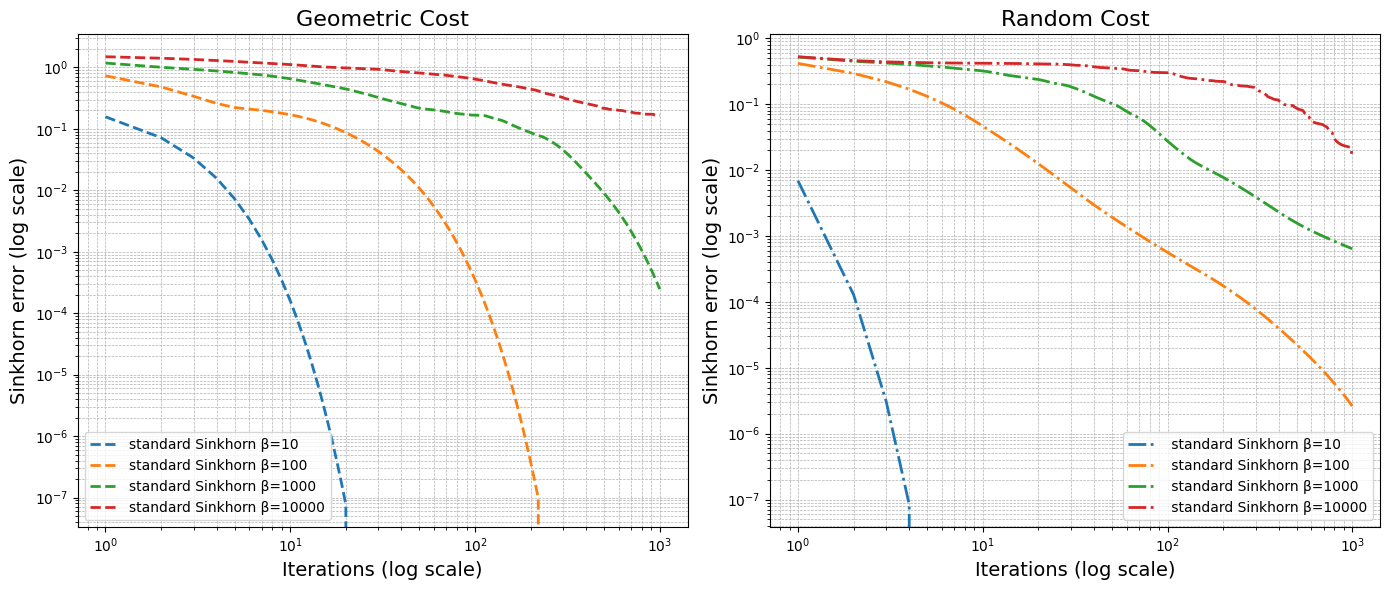

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Geometric Cost ---
ax = axes[0]
for beta in betas:
    errors = errors_pc[beta]
    iterations = jnp.arange(1, len(errors)+1)
    ax.plot(iterations, errors, '--', linewidth=2, label=f"standard Sinkhorn β={beta}")

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1, niter)
# ax.set_ylim(1e-7, 1e1)
ax.set_xlabel("Iterations (log scale)", fontsize=14)
ax.set_ylabel("Sinkhorn error (log scale)", fontsize=14)
ax.set_title("Geometric Cost", fontsize=16)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend(fontsize=10, loc='best')

# Random Cost ---
ax = axes[1]
for beta in betas:
    errors = errors_rand[beta]
    iterations = jnp.arange(1, len(errors)+1)
    ax.plot(iterations, errors, '-.', linewidth=2, label=f" standard Sinkhorn β={beta}")

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1, niter)
# ax.set_ylim(1e-7, 1e1)
ax.set_xlabel("Iterations (log scale)", fontsize=14)
ax.set_ylabel("Sinkhorn error (log scale)", fontsize=14)
ax.set_title("Random Cost", fontsize=16)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.show()


**Interpretation:**


Typically, as **$\beta$ increases** (i.e., $\varepsilon$ decreases), the **Sinkhorn error (constraint violation) decreases**, indicating more accurate transport plans but requiring **more iterations** to converge. In the case of **geometric costs** (structured problems), the Sinkhorn error decreases faster and reaches lower values compared to the **random costs** (unstructured problems), suggesting that structured problems benefit more from using higher $\beta$ values. This observation supports the idea that **annealing strategies** (gradually decreasing $\varepsilon$) can yield even larger gains in structured settings where transport problems exhibit geometric regularity.

**Observation:**


No single fixed $\beta$ run dominates all others; to get both fast initial decrease and low final error, we would need to change $\beta$ over time – this is exactly what annealing does. Next, we'll implement annealed Sinkhorn and see how it compares.

However in order to have the pereto front as proposed in paper, we also implement the sinkhorn algorithm that can track the gap cost each iteration.

In [44]:
betas = [10,100,1000]
n_iter = 1000

gaps_fixed_beta_pc = {}
gaps_fixed_beta_rand = {}

# for geometric (pointcloud) data
for beta in betas:
    print(f"Running Sinkhorn for β={beta:.2f} (geometric)")
    gaps = sinkhorn_track_gap_cost_fixed_beta(
        geom=geom_pc,
        p=p,
        q=q,
        beta=beta,
        true_cost=true_ot_cost_pc,
        max_iters=n_iter
    )
    gaps_fixed_beta_pc[beta] = gaps

# for random cost data
for beta in betas:
    print(f"Running Sinkhorn for β={beta:.2f} (random)")
    gaps = sinkhorn_track_gap_cost_fixed_beta(
        geom=geom_rand,
        p=p,
        q=q,
        beta=beta,
        true_cost=true_ot_cost_rand,
        max_iters=n_iter
    )
    gaps_fixed_beta_rand[beta] = gaps

Running Sinkhorn for β=10.00 (geometric)
Running Sinkhorn for β=100.00 (geometric)
Running Sinkhorn for β=1000.00 (geometric)
Running Sinkhorn for β=10.00 (random)
Running Sinkhorn for β=100.00 (random)
Running Sinkhorn for β=1000.00 (random)


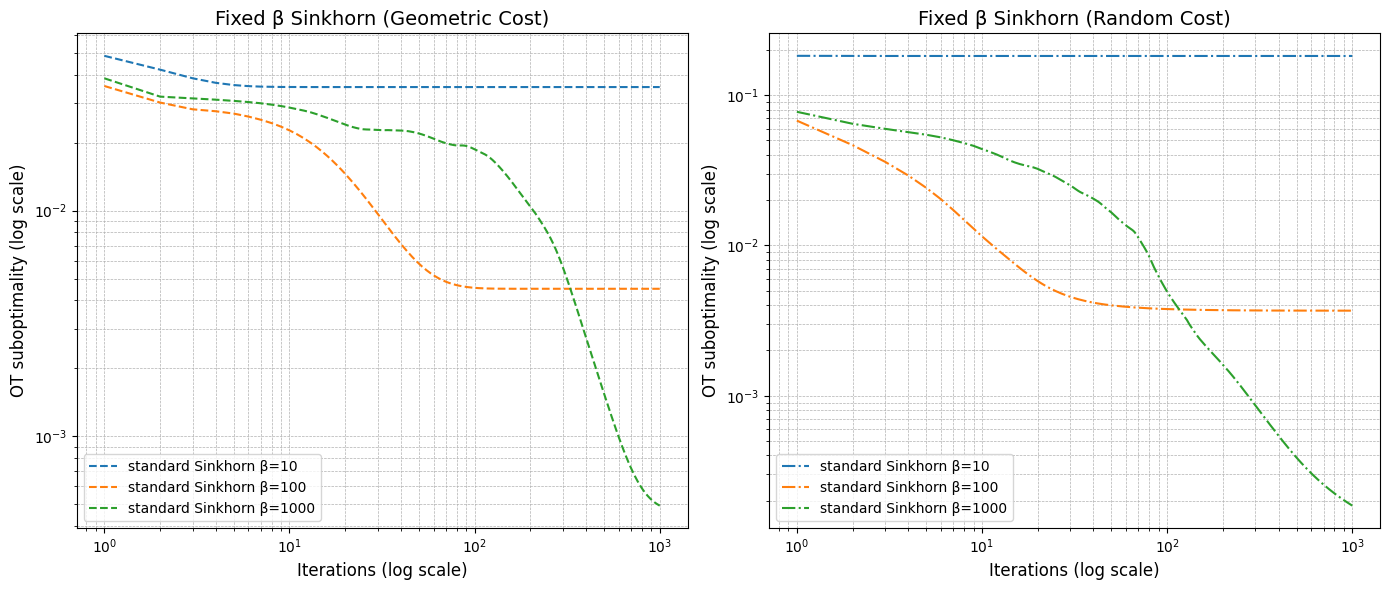

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Geometric Cost
ax = axes[0]
for beta in betas:
    gaps = gaps_fixed_beta_pc[beta]
    ax.plot(jnp.arange(1, n_iter+1), gaps, '--', label=f"standard Sinkhorn β={beta}")

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1, n_iter)
# ax.set_ylim(1e-7, 1e3)
ax.set_xlabel("Iterations (log scale)", fontsize=12)
ax.set_ylabel("OT suboptimality (log scale)", fontsize=12)
ax.set_title("Fixed β Sinkhorn (Geometric Cost)", fontsize=14)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend(fontsize=10)

# Random Cost
ax = axes[1]
for beta in betas:
    gaps = gaps_fixed_beta_rand[beta]
    ax.plot(jnp.arange(1, n_iter+1), gaps, '-.', label=f"standard Sinkhorn β={beta}")

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1, n_iter)
# ax.set_ylim(1e-7, 1e3)
ax.set_xlabel("Iterations (log scale)", fontsize=12)
ax.set_ylabel("OT suboptimality (log scale)", fontsize=12)
ax.set_title("Fixed β Sinkhorn (Random Cost)", fontsize=14)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


## Annealed Sinkhorn in OTT-JAX

OTT-JAX supports annealing through an $\varepsilon$ scheduler. The `geometry.Epsilon` scheduler uses a [geometric decay](https://ott-jax.readthedocs.io/en/latest/_autosummary/ott.geometry.epsilon_scheduler.Epsilon.html) strategy by default: specify a target $\varepsilon_{\text{target}}$, an initial multiplier, and a decay rate​. This yields $\varepsilon_t = \varepsilon_{\text{target}} \cdot (\text{init} \cdot \text{decay}^t)$.

Since:
$$
\beta_t = \frac{1}{\varepsilon_t}
$$

this implies:
$$
\log(\beta_t) = -\log(\varepsilon_{\text{target}}) - \log(\text{init}) - t \log(\text{decay})
$$

thus:
$$
\log(\beta_t) \quad \text{grows linearly with} \quad t
$$

which means:
- $\beta_t$ grows **exponentially** with $t$,
- instead of polynomially ($t^\kappa$).

However, to start simple, let's use the built-in scheduler to mimic a concave increasing $\beta$. For example, we target a final $\beta_{\text{max}}$ and set a decay such that $\beta$ grows slowly.

In OTT-JAX, we create a scheduler and attach it to the geometry:

In [47]:
from ott.geometry import epsilon_scheduler

# Scheduler parameters
target_eps = 0.001
init_eps = 0.1
init_multiplier = init_eps / target_eps
n_iter = 1000
# tol = 1e-7
decay = (1.0 / init_multiplier) ** (1.0 / n_iter)  # smooth decay over 1000 iterations

# Scheduler for geometric cost
scheduler_geo = epsilon_scheduler.Epsilon(target=target_eps, init=init_multiplier, decay=decay)
geom_geo_sched = pointcloud.PointCloud(X, Y, cost_fn=costs.SqEuclidean(), epsilon=scheduler_geo)

# Scheduler for random cost
scheduler_rand = epsilon_scheduler.Epsilon(target=target_eps, init=init_multiplier, decay=decay)
geom_rand_sched = geometry.Geometry(cost_matrix=cost_rand, epsilon=scheduler_rand)


In [48]:
solver = sinkhorn.Sinkhorn(
    max_iterations=n_iter,
    # threshold=tol,
    inner_iterations=1,
    implicit_diff=False
)
# Solve for geometric cost
problem_geo = linear_problem.LinearProblem(geom_geo_sched, a=p, b=q)
out_geo = solver(problem_geo)
print(f"Annealed Sinkhorn (geometric) converged in {out_geo.n_iters} iterations, cost={out_geo.reg_ot_cost:.4f}")

# Solve for random cost
problem_rand = linear_problem.LinearProblem(geom_rand_sched, a=p, b=q)
out_rand = solver(problem_rand)
print(f"Annealed Sinkhorn (random) converged in {out_rand.n_iters} iterations, cost={out_rand.reg_ot_cost:.4f}")

Annealed Sinkhorn (geometric) converged in 1000 iterations, cost=0.0894
Annealed Sinkhorn (random) converged in 1000 iterations, cost=0.1802


The above sets up an annealing schedule that gradually decreases $\varepsilon$ (increases $\beta$) every iteration. We then run the Sinkhorn solver normally–it will internally use the scheduler each iteration.

While we track Sinkhorn error during annealing, tracking the exact cost gap over time would require custom looped Sinkhorn updates with access to intermediate potentials, which OTT-JAX does not expose by default.

To examine convergence behavior, let's track the error over iterations. OTT’s `SinkhornOutput` stores a history of errors (`out.errors`) if enabled.

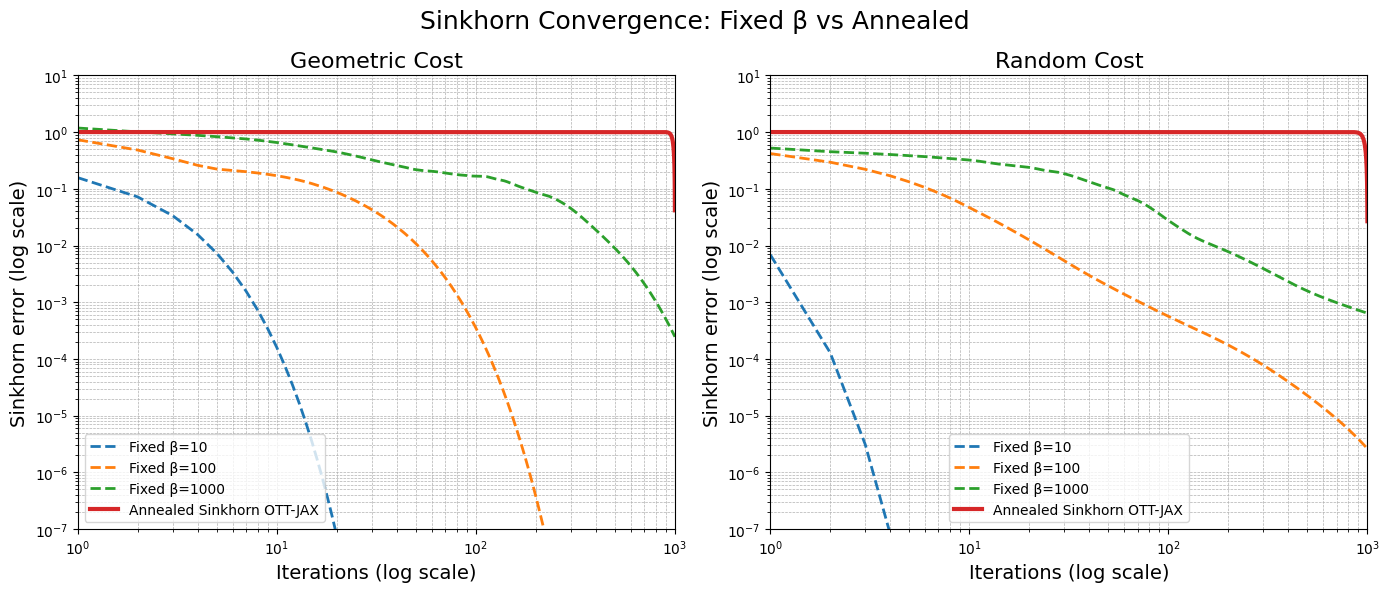

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Geometric Cost
ax = axes[0]
for beta in betas:
    errors = errors_pc[beta]
    iterations = jnp.arange(1, len(errors) + 1)
    ax.plot(iterations, errors, '--', linewidth=2, label=f"Fixed β={beta}")

# Annealed Sinkhorn (Geometric)
iterations_geo = jnp.arange(1, len(out_geo.errors) + 1)
ax.plot(iterations_geo, out_geo.errors, '-', linewidth=3, label="Annealed Sinkhorn OTT-JAX")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, n_iter)
ax.set_ylim(1e-7, 1e1)
ax.set_xlabel("Iterations (log scale)", fontsize=14)
ax.set_ylabel("Sinkhorn error (log scale)", fontsize=14)
ax.set_title("Geometric Cost", fontsize=16)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend(fontsize=10)

# Random Cost
ax = axes[1]
for beta in betas:
    errors = errors_rand[beta]
    iterations = jnp.arange(1, len(errors) + 1)
    ax.plot(iterations, errors, '--', linewidth=2, label=f"Fixed β={beta}")

# Annealed Sinkhorn (Random)
iterations_rand = jnp.arange(1, len(out_rand.errors) + 1)
ax.plot(iterations_rand, out_rand.errors, '-', linewidth=3, label="Annealed Sinkhorn OTT-JAX")

# Formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, n_iter)
ax.set_ylim(1e-7, 1e1)
ax.set_xlabel("Iterations (log scale)", fontsize=14)
ax.set_ylabel("Sinkhorn error (log scale)", fontsize=14)
ax.set_title("Random Cost", fontsize=16)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend(fontsize=10)

plt.suptitle("Sinkhorn Convergence: Fixed β vs Annealed", fontsize=18)
plt.tight_layout()
plt.show()


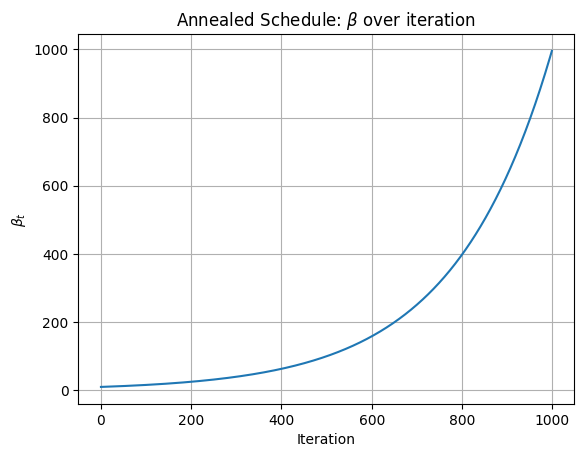

In [50]:
epsilons = [scheduler_geo(t) for t in range(n_iter)]
betas = [1.0 / eps for eps in epsilons]

plt.plot(jnp.arange(n_iter), betas)
plt.xlabel("Iteration")
plt.ylabel(r"$\beta_t$")
plt.title( r"Annealed Schedule: $\beta$ over iteration")
plt.grid(True)
plt.show()


**Interpretation:**  
This plot shows how the inverse regularization strength $\beta_t$ evolves over time during Annealed Sinkhorn. As intended, βₜ increases exponentially due to the geometric $ϵ$ decay, plateauing at the target maximum value (here, $\beta$ = 1000) around iteration 1000. This schedule mimics a concave $\beta_t$ growth, which balances fast convergence early on with accurate results at the end — the key idea behind annealing.


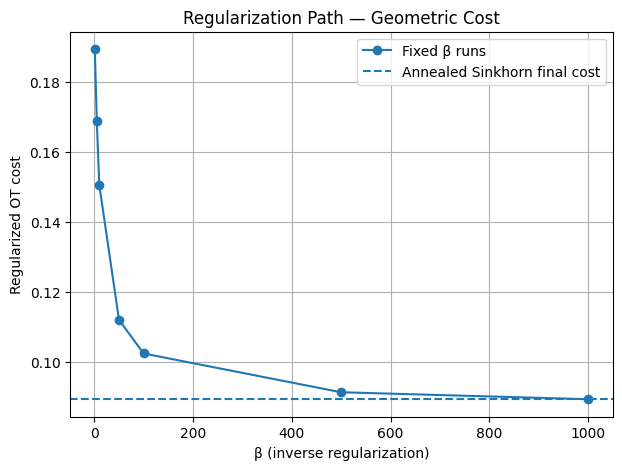

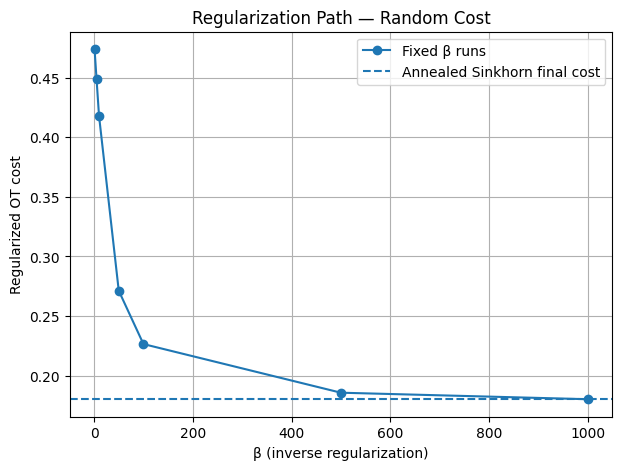

In [51]:
def plot_regularization_path(geom_builder, cost_matrix_name):
    betas_path = [1, 5, 10, 50, 100, 500, 1000]
    costs_fixed = []

    for beta in betas_path:
        eps = 1.0 / beta
        geom_fixed = geom_builder(eps)
        prob = linear_problem.LinearProblem(geom_fixed, a=p, b=q)
        out = sinkhorn.Sinkhorn()(prob)
        costs_fixed.append(out.reg_ot_cost)

    # Annealed Sinkhorn
    scheduler = epsilon_scheduler.Epsilon(target=1/1000, init=1000, decay=(1/1000)**(1/1000))
    geom_annealed = geom_builder(scheduler)
    prob_annealed = linear_problem.LinearProblem(geom_annealed, a=p, b=q)
    out_annealed = sinkhorn.Sinkhorn()(prob_annealed)

    plt.figure(figsize=(7, 5))
    plt.plot(betas_path, costs_fixed, "o-", label="Fixed β runs")
    plt.axhline(out_annealed.reg_ot_cost, linestyle="--", label="Annealed Sinkhorn final cost")
    plt.xlabel("β (inverse regularization)")
    plt.ylabel("Regularized OT cost")
    plt.title(f"Regularization Path — {cost_matrix_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_regularization_path(lambda eps: pointcloud.PointCloud(X, Y, cost_fn=costs.SqEuclidean(), epsilon=eps), "Geometric Cost")
plot_regularization_path(lambda eps: geometry.Geometry(cost_matrix=cost_rand, epsilon=eps), "Random Cost")


**Interpretation:**

These plots visualize the regularization path, how the regularized OT cost evolves with increasing β (i.e., decreasing ε). Each dot corresponds to the output of a separate fixed-β Sinkhorn run, while the dashed line shows the final cost obtained from a single annealed Sinkhorn run using **OTT-JAX's built-in scheduler**.

We observe that the annealed Sinkhorn run closely matches the final costs of much more expensive fixed-β sweeps, confirming that annealing can **efficiently approximate the entire regularization path in a single pass**. This behavior holds across both structured (geometric) and unstructured (random) cost settings, although convergence is faster and smoother for structured problems.


## Annealed Sinkhorn as proposed in [paper](https://arxiv.org/pdf/2408.11620)

The above implementation, we use a **geometric decay** for the regularization parameter $\varepsilon_t$, leading to an exponential increase in $\beta_t$. While this does not strictly match the polynomial $\beta_t \sim t^\kappa$ schedule described in Algorithm 1 of the Annealed Sinkhorn paper, it captures the key idea of gradually reducing regularization during optimization. This approximation allows efficient implementation using OTT-JAX's epsilon scheduler.

To more faithfully reproduce the Annealed Sinkhorn algorithm (Algorithm 1 in the paper), we implement it manually with:
- A polynomial schedule for $\beta_t = \beta_0(t+1)^\kappa$
- Optional debiasing
- Periodic $\beta$ updates (controlled by plateau_length), as proposed in the [paper](https://arxiv.org/pdf/2408.11620)
- Cost gap tracking

In [52]:
# Annealed Sinkhorn algorithm with a few tracking functionalities
def sinkhorn_annealed_track_gap_cost(
    geom, p, q, true_cost,
    beta_0=10.0, kappa=2/3,
    max_iters=1000, debiased=True,
    iter_stop=None, plateau_length=1
):
    C = geom.cost_matrix.astype(jnp.float64)
    p = p.astype(jnp.float64)
    q = q.astype(jnp.float64)
    lp = jnp.log(p)
    lq = jnp.log(q)

    u = jnp.zeros_like(p, dtype=jnp.float64)
    v = jnp.zeros_like(q, dtype=jnp.float64)

    beta = beta_0
    gaps = []

    if iter_stop is None:
        iter_stop = max_iters

    for t in range(1, max_iters + 1):
        if debiased and t <= iter_stop:
            ratio = (t**kappa - (t - 1)**kappa) / (t**kappa)
            temp1 = v[None, :] + lq[None, :] - beta * C
            temp1 = temp1 - ratio * u[:, None]
        else:
            temp1 = v[None, :] + lq[None, :] - beta * C

        stab1 = jnp.max(temp1, axis=1)
        u = -stab1 - jnp.log(jnp.sum(jnp.exp(temp1 - stab1[:, None]), axis=1))

        # Update beta at sqrt(t) intervals
        if t <= iter_stop and int(jnp.floor(jnp.sqrt(t))) % plateau_length == 0:
            beta = beta_0 * (t + 1)**kappa

        temp2 = u[:, None] + lp[:, None] - beta * C
        stab2 = jnp.max(temp2, axis=0)
        v = -stab2 - jnp.log(jnp.sum(jnp.exp(temp2 - stab2[None, :]), axis=0))

        # Construct pi and project
        pi = jnp.exp(u[:, None] + lp[:, None] + v[None, :] + lq[None, :] - beta * C)
        pi_proj = projection_plan(p, q, pi)

        gap = jnp.sum(C * pi_proj) - true_cost
        gaps.append(gap)

    return jnp.array(gaps)


In [55]:
betas = [10,1000]
n_iter = 1000

gaps_fixed_beta_pc = {}
gaps_fixed_beta_rand = {}
gaps_annealed_pc = {}
gaps_annealed_rand = {}
gaps_debaised_annealed_pc = {}
gaps_debaised_annealed_rand = {}

# for geometric (pointcloud) data
for beta in betas:
    print(f"Running Sinkhorn for β={beta:.2f} (geometric)")
    gaps = sinkhorn_track_gap_cost_fixed_beta(
        geom=geom_pc,
        p=p,
        q=q,
        beta=beta,
        true_cost=true_ot_cost_pc,
        max_iters=n_iter
    )
    gaps_fixed_beta_pc[beta] = gaps

# for random cost data
for beta in betas:
    print(f"Running Sinkhorn for β={beta:.2f} (random)")
    gaps = sinkhorn_track_gap_cost_fixed_beta(
        geom=geom_rand,
        p=p,
        q=q,
        beta=beta,
        true_cost=true_ot_cost_rand,
        max_iters=n_iter
    )
    gaps_fixed_beta_rand[beta] = gaps


# Annealed Sinkhorn κ = 1/2 (non-debiased)
print("Running Anneal Sinkhorn κ = 1/2 (geometric)")
gaps_annealed_pc[0.5] = sinkhorn_annealed_track_gap_cost(
    geom=geom_pc,
    p=p,
    q=q,
    true_cost=true_ot_cost_pc,
    beta_0=10.0,
    kappa=0.5,
    max_iters=n_iter,
    debiased=False
)
print("Running Anneal Sinkhorn κ = 1/2 (random)")
gaps_annealed_rand[0.5] = sinkhorn_annealed_track_gap_cost(
    geom=geom_rand,
    p=p,
    q=q,
    true_cost=true_ot_cost_rand,
    beta_0=10.0,
    kappa=0.5,
    max_iters=n_iter,
    debiased=False
)

# Annealed Sinkhorn κ = 2/3 (debiased)
print("Running Debaised Anneal Sinkhorn κ = 2/3 (geometric)")
gaps_debaised_annealed_pc[2/3] = sinkhorn_annealed_track_gap_cost(
    geom=geom_pc,
    p=p,
    q=q,
    true_cost=true_ot_cost_pc,
    beta_0=10.0,
    kappa=2/3,
    max_iters=n_iter,
    debiased=True
)
print("Running Debaised Anneal Sinkhorn κ = 2/3 (random)")
gaps_debaised_annealed_rand[2/3] = sinkhorn_annealed_track_gap_cost(
    geom=geom_rand,
    p=p,
    q=q,
    true_cost=true_ot_cost_rand,
    beta_0=10.0,
    kappa=2/3,
    max_iters=n_iter,
    debiased=True
)


Running Sinkhorn for β=10.00 (geometric)
Running Sinkhorn for β=1000.00 (geometric)
Running Sinkhorn for β=10.00 (random)
Running Sinkhorn for β=1000.00 (random)
Running Anneal Sinkhorn κ = 1/2 (geometric)
Running Anneal Sinkhorn κ = 1/2 (random)
Running Debaised Anneal Sinkhorn κ = 2/3 (geometric)
Running Debaised Anneal Sinkhorn κ = 2/3 (random)


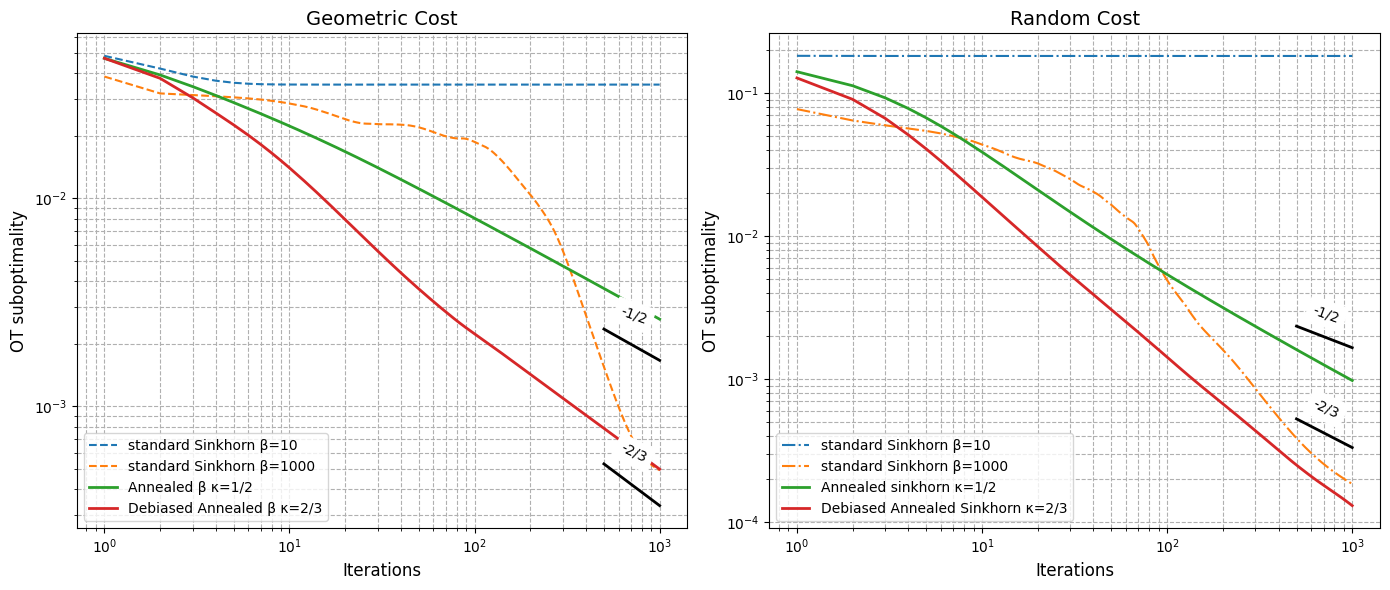

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Geometric Cost
ax = axes[0]
for beta in betas:
    ax.plot(jnp.arange(1, n_iter+1), gaps_fixed_beta_pc[beta], '--', label=f"standard Sinkhorn β={beta}")
ax.plot(jnp.arange(1, n_iter+1), gaps_annealed_pc[0.5], label="Annealed β κ=1/2", linewidth=2)
ax.plot(jnp.arange(1, n_iter+1), gaps_debaised_annealed_pc[2/3], label="Debiased Annealed β κ=2/3", linewidth=2)

t_vals = jnp.arange(500, 1001, 10)
ax.plot(t_vals, (t_vals)**(-0.5) / 19, 'k', lw=2)
ax.text(600, 0.0025, "-1/2", color="black", size=10, backgroundcolor="white", rotation=-20)

ax.plot(t_vals, (t_vals)**(-2/3) / 30, 'k', lw=2)
ax.text(600, 0.00054, "-2/3", color="black", size=10, backgroundcolor="white", rotation=-25)

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(1, n_iter)
# ax.set_ylim(1e-5, 1e2)
ax.set_title("Geometric Cost", fontsize=14)
ax.set_xlabel("Iterations", fontsize=12)
ax.set_ylabel("OT suboptimality", fontsize=12)
ax.grid(True, which="both", linestyle="--")
ax.legend()

# Random Cost
ax = axes[1]
for beta in betas:
    ax.plot(jnp.arange(1, n_iter+1), gaps_fixed_beta_rand[beta], '-.', label=f"standard Sinkhorn β={beta}")
ax.plot(jnp.arange(1, n_iter+1), gaps_annealed_rand[0.5], label="Annealed sinkhorn κ=1/2", linewidth=2)
ax.plot(jnp.arange(1, n_iter+1), gaps_debaised_annealed_rand[2/3], label="Debiased Annealed Sinkhorn κ=2/3", linewidth=2)

ax.plot(t_vals, (t_vals)**(-0.5) / 19, 'k', lw=2)
ax.text(600, 0.0025, "-1/2", color="black", size=10, backgroundcolor="white", rotation=-20)

ax.plot(t_vals, (t_vals)**(-2/3) / 30, 'k', lw=2)
ax.text(600, 0.00054, "-2/3", color="black", size=10, backgroundcolor="white", rotation=-25)

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(1, n_iter)
# ax.set_ylim(1e-5, 1e2)
ax.set_title("Random Cost", fontsize=14)
ax.set_xlabel("Iterations", fontsize=12)
ax.set_ylabel("OT suboptimality", fontsize=12)
ax.grid(True, which="both", linestyle="--")
ax.legend()

plt.tight_layout()
plt.show()


**Interpretation:**

These plots show the convergence behavior of various Sinkhorn variants on structured (geometric) and unstructured (random) optimal transport problems.

- **Fixed β Sinkhorn** converges quickly at first but plateaus due to entropic bias, leading to suboptimal solutions.
- **Annealed Sinkhorn** (κ = ½) improves this trade-off by gradually increasing β, reducing entropic bias over time.
- **Debiased Annealed Sinkhorn** (κ = ⅔) combines fast convergence and low final error by correcting the lag introduced during annealing.

The empirical decay of the OT suboptimality closely matches the theoretical convergence rates of $t^{-1/2}$ and $t^{-2/3}$, confirming the effectiveness of annealing and debiasing.

This demonstrates that Debiased Annealed Sinkhorn provides a near-optimal regularization path, achieving both speed and precision without manual β tuning.


## Error as a function of scaling exponent

 $\kappa sweep ({name}): 100%|██████████| 30/30 [02:30<00:00,  5.03s/it]


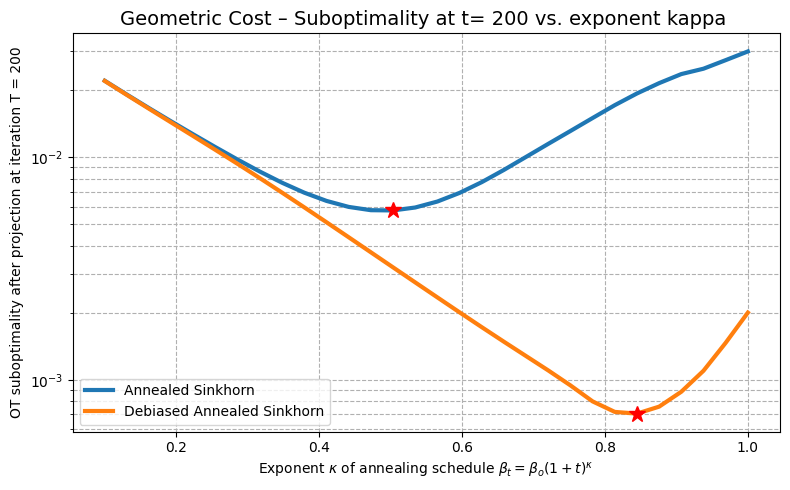

 $\kappa sweep ({name}): 100%|██████████| 30/30 [02:31<00:00,  5.07s/it]


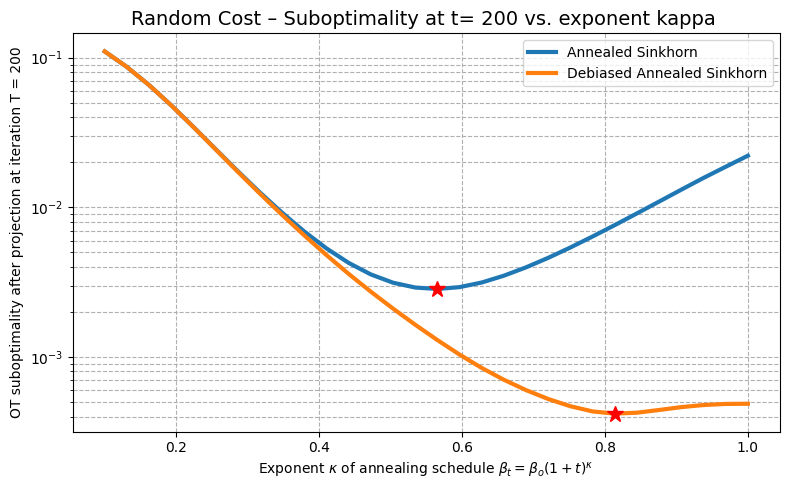

In [57]:
from tqdm import tqdm

# Sweep over kappa values
kappas = jnp.linspace(0.1, 1.0, 30)
n_iter = 200
beta_0 = 10.0

for name, geom, true_cost in [("Geometric", geom_pc, true_ot_cost_pc),
                              ("Random", geom_rand, true_ot_cost_rand)]:
    errors_biased = jnp.zeros_like(jnp.array(kappas))
    errors_debiased = jnp.zeros_like(jnp.array(kappas))

    for i, kappa in enumerate(tqdm(kappas, desc=r" $\kappa sweep ({name})")):
        gaps_b = sinkhorn_annealed_track_gap_cost(
            geom=geom, p=p, q=q, true_cost=true_cost,
            beta_0=beta_0, kappa=kappa, max_iters=n_iter, debiased=False
        )
        errors_biased = errors_biased.at[i].set(gaps_b[-1])

        gaps_d = sinkhorn_annealed_track_gap_cost(
            geom=geom, p=p, q=q, true_cost=true_cost,
            beta_0=beta_0, kappa=kappa, max_iters=n_iter, debiased=True
        )
        errors_debiased = errors_debiased.at[i].set(gaps_d[-1])

    plt.figure(figsize=(8, 5))
    plt.semilogy(kappas, errors_biased, label="Annealed Sinkhorn", linewidth=3)
    plt.semilogy(kappas, errors_debiased, label="Debiased Annealed Sinkhorn", linewidth=3)

    min_b = jnp.argmin(errors_biased)
    min_d = jnp.argmin(errors_debiased)
    plt.plot(kappas[min_b], errors_biased[min_b], "r*", markersize=12)
    plt.plot(kappas[min_d], errors_debiased[min_d], "r*", markersize=12)

    plt.xlabel(r"Exponent $\kappa$ of annealing schedule $\beta_t = \beta_o(1+t)^\kappa$ ", fontsize=10)
    plt.ylabel(f"OT suboptimality after projection at iteration T = {n_iter}", fontsize=10)
    plt.title(f"{name} Cost – Suboptimality at t= {n_iter} vs. exponent kappa ", fontsize=14)
    plt.grid(True, which="both", linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

**Interpretation:**

This plot shows how the final OT suboptimality (after 200 iterations) depends on the exponent κ in the annealing schedule $\beta_t = \beta_0(1+t)^{\kappa}$.

- For both structured (Geometric) and unstructured (Random) cost settings, we see that:
  - **Standard Annealed Sinkhorn** performs best around $\kappa = \frac{1}{2}$.
  - **Debiased Annealed Sinkhorn** achieves lowest error around $\kappa = \frac{2}{3}$.
This empirically confirms the theoretical analysis in the paper, which predicts:
- An optimal rate of $t^{-1/2}$ for standard annealing at $\kappa = \frac{1}{2}$.
- An improved rate of $t^{-2/3}$ for debiased annealing at $\kappa = \frac{2}{3}$.

## Piecewise-Constant Schedules

A practical trick with annealing is to use plateaus: hold $\beta$ constant for a while, then jump​. The idea is to let Sinkhorn converge at intermediate $\beta$ values before increasing further. While this can improve performance over naive continuous growth, the paper found it “less effective” than the debiasing strategy​


Running schedules on Geometric cost matrix...


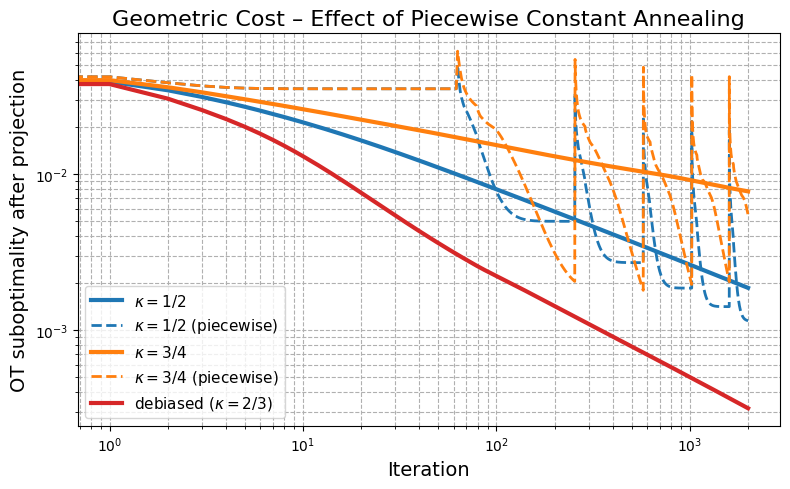


Running schedules on Random cost matrix...


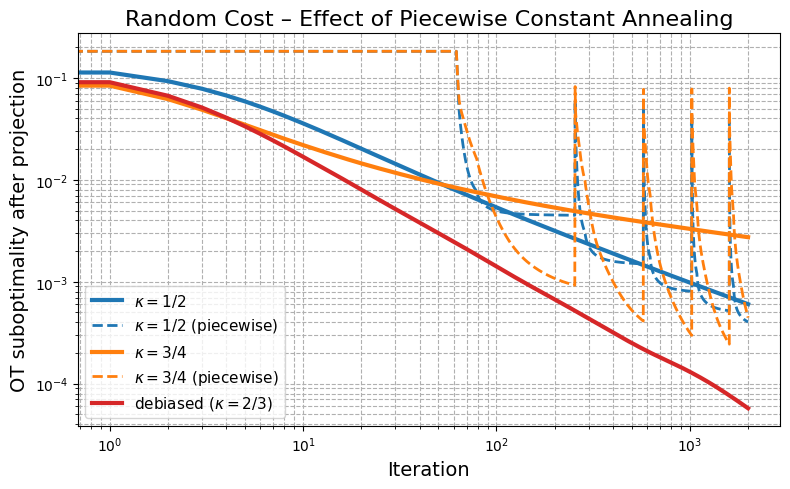

In [58]:
n_iter = 2000
beta_0 = 10.0

schedules = [
    {"kappa": 0.5, "plateau_length": 1, "label": r"$\kappa=1/2$", "style": "C0", "deb": False},
    {"kappa": 0.5, "plateau_length": 8, "label": r"$\kappa=1/2$ (piecewise)", "style": "C0--", "deb": False},
    {"kappa": 0.75, "plateau_length": 1, "label": r"$\kappa=3/4$", "style": "C1", "deb": False},
    {"kappa": 0.75, "plateau_length": 8, "label": r"$\kappa=3/4$ (piecewise)", "style": "C1--", "deb": False},
    {"kappa": 2/3, "plateau_length": 1, "label": r"debiased ($\kappa=2/3$)", "style": "C3", "deb": True},
]

for name, geom, true_cost in [("Geometric", geom_pc, true_ot_cost_pc),
                              ("Random", geom_rand, true_ot_cost_rand)]:

    plt.figure(figsize=(8, 5))
    print(f"\nRunning schedules on {name} cost matrix...")

    for sched in schedules:
        err = sinkhorn_annealed_track_gap_cost(
            geom=geom, p=p, q=q, true_cost=true_cost,
            beta_0=beta_0,
            kappa=sched["kappa"],
            max_iters=n_iter,
            debiased=sched["deb"],
            plateau_length=sched["plateau_length"]
        )
        if "C" in sched["style"] and "--" in sched["style"]:
            plt.semilogy(err, sched["style"], label=sched["label"], linewidth=2)
        else:
            plt.loglog(err, sched["style"], label=sched["label"], linewidth=3)

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("OT suboptimality after projection", fontsize=14)
    plt.title(f"{name} Cost – Effect of Piecewise Constant Annealing", fontsize=16)
    plt.grid(True, which="both", linestyle="--")
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

**Interpretation**

This experiment evaluates piecewise-constant annealing schedules, where the regularization strength $\beta$ is held constant for several iterations before being increased. While this strategy provides temporary convergence speedups (visible as sharp error drops after each $\beta$ update), it also introduces instability, especially in unstructured (random) cost settings.

In both the geometric and random cost cases, the **debiasing strategy** (red curve) consistently achieves the lowest OT suboptimality and the most stable convergence. These results confirm the findings from the original paper: while piecewise annealing can offer improvements over naive continuous schedules, **debiasing remains the most effective and reliable approach**.


## Summary

- **Convergence Behavior**: We observed that a concave increasing schedule for $\beta$ (like $\sqrt{t}$) ensures the Sinkhorn iterates converge to the true OT solution. Empirically, the error decays roughly as $t^{-1/2}$. We also confirmed that overly aggressive (larger $\kappa$) or overly slow (smaller $\kappa$) annealing schedules lead to slower convergence or poor final accuracy.

- **Debiased Annealing**: By introducing a simple projection-based correction (as proposed in the paper), we implemented **Debiased Annealed Sinkhorn**, which allowed for faster $\beta$ growth ($\kappa \approx 2/3$). This consistently achieved **lower suboptimality** and matched the theoretical $t^{-2/3}$ convergence rate.

- **Effect of Cost Structure**: Structured (geometric) transport problems benefit more from annealing than unstructured (random) ones, and convergence tends to be faster and more stable in the geometric case.

- **Piecewise-Constant Scheduling**: Holding $\beta$ constant for intervals (plateauing) can temporarily improve convergence, but this strategy introduced oscillations and proved less effective than debiasing, especially for unstructured problems.

- **Overall Finding**: Among all methods tested, **Debiased Annealed Sinkhorn** with $\beta_t \propto (1 + t)^{2/3}$ was the most efficient and robust, providing a near-optimal trade-off between speed and accuracy **without requiring manual β tuning**.

This notebook successfully explore various concept and the main results of [Chizat (2024)](https://arxiv.org/abs/2408.11620).

## References
- [Lénaïc Chizat (2024). Annealed Sinkhorn for Optimal Transport: convergence, regularization path and debiasing. ArXiv, abs/2408.11620.](https://arxiv.org/pdf/2408.11620)
- https://github.com/lchizat/annealed-sinkhorn/tree/main